In [5]:
%load_ext autoreload
%autoreload 2
import seaborn as sns
import glob
import os
import numpy as np
import sys
sys.path.append( '../src/')
from matplotlib import pyplot as plt
# from compile_treeset import compile_folder , compare_treesets


In [6]:

import glob
import pandas as pd
import json
import os
import tqdm
from itertools import combinations
import plotly.express as px
import plotly.figure_factory as ff
from scipy.stats import wilcoxon
import numpy as np


def compile_folder_resdict(rootfolder , scorefunc = 'score_x_frac' , verbose = False):

    """
    this function compiles the treescores for all the trees in a folder
    it checks that the number of sequences and structures are the same
    it also checks that the treescores are present

    params:
        rootfolder: folder with the treescores
        scorefunc: treescore to use
    returns:
        resdf: dataframe with the treescores
        refclols: list of the columns in the dataframe

    """
    
    print(rootfolder)
    res = {}
    folders = set(glob.glob(rootfolder + '*/' ))-set([rootfolder+'logs/'])
    print(len(folders))
    if len(folders)>0:
        with tqdm.tqdm(total=len(folders)) as pbar:
            for i,folder in enumerate(folders):
                nstructs = len(glob.glob(folder+'structs/*.pdb'))
                if os.path.isfile(folder+'sequences.aln.muscle.fst.nwk.rooted'):
                    treescores = glob.glob(folder + '*_treescores_struct_tree.json' ) + list(glob.glob(folder+'treescores_sequences*.json')) + list(glob.glob( folder+'treescores_sequences_iq*.json'))
                    if len(treescores)>0 and os.path.isfile(folder + 'sequences.fst'):
                        with open(folder + 'sequences.fst') as fstin:
                            nseqs = fstin.read().count('>')
                        pbar.set_description('processed: %d' % (1 + i))
                        pbar.update(1)
                        if nseqs == nstructs :
                            for score in treescores:
                                #check if score exists
                                if os.path.isfile(score):

                                    with open(score) as taxin:
                                        tax_res = json.load(taxin)
                                    tax_res= {s.split('/')[-1]:tax_res[s] for s in tax_res}
                                    if folder not in res:
                                        res[folder] = { s:tax_res[s][scorefunc] for s in tax_res if  scorefunc  in tax_res[s]}
                                    else:
                                        res[folder].update({ s:tax_res[s][scorefunc] for s in tax_res if scorefunc in tax_res[s]})

                            res[folder].update({ 'nseqs':   nseqs})
                        else:
                            if verbose == True:
                                print('nseqs != nstructs', folder)
                                print(nseqs, nstructs)
            return res
                            
def compile_folder(rootfolder , scorefunc = 'score_x_frac' , verbose = False):
    '''
    This function compiles the treescores for all the trees in a folder
    it checks that the number of sequences and structures are the same
    it also checks that the treescores are present
    
    '''

    res = compile_folder_resdict(rootfolder , scorefunc = scorefunc , verbose = verbose)
    if len(res)>0:
        resdf = pd.DataFrame.from_dict(res, orient = 'index')
        resdf.columns = [ c.replace('.PP.nwk.rooted', '').replace('.aln.fst.nwk.rooted' , '' ) for c in  resdf.columns]
        if verbose == True:
            print(resdf.head(), resdf.shape)
        refcols = list(resdf.columns)
        refcols.remove('nseqs')

        #divide the scores by the number of sequences
        for c in refcols:
            resdf[c+'_norm'] = resdf[c] / resdf['nseqs']

        for c1,c2 in combinations(refcols,2):
            resdf[c1+'_'+c2+'_delta'] = resdf[c1] - resdf[c2]
            resdf[c1+'_'+c2+'_max'] = resdf[[c1,c2]].apply( max , axis = 1)

            resdf[c1+'_'+c2+'_delta_norm'] = resdf[c1+'_'+c2+'_delta'] / resdf[c1+'_'+c2+'_max']
        resdf['clade'] = rootfolder.split('/')[-2]
        resdf['family'] = resdf.index.map( lambda x :  x.split('/')[-2])

        return resdf, refcols

def compile_folder_treestats(rootfolder , scorefunc = 'ultrametricity_norm' , verbose = False):
    res = compile_folder_resdict(rootfolder , scorefunc = scorefunc , verbose = verbose)
    if len(res)>0:
        resdf = pd.DataFrame.from_dict(res, orient = 'index')
        #resdf.columns = [ c.replace('.PP.nwk.rooted', '').replace('.aln.fst.nwk.rooted' , '' ) for c in  resdf.columns]
        if verbose == True:
            print(resdf.head(), resdf.shape)
        return resdf
    
def compare_treesets(tree_resdf , colfilter= 'sequence' , display_lineplot = False , display_distplot = True , verbose = False):

    '''
    this function compares the treescores for all the trees in a folder
    it uses ploty to plot the results and performs a wilcoxon test

     params:
        tree_resdf: dataframe with the treescores
        colfilter: string to filter the columns to compare
    returns:
        None
    '''
    rescols = [ 'p_value_struct_tree' , 'score_struct_tree',   'sequences' ]
    refcols = [ 'p_value_struct_tree' , 'score_struct_tree', 'sequences' ]


    for c1,c2 in combinations(refcols,2):
        if colfilter in c1 or colfilter in c2:
            try:
                if verbose == True:
                    print(c1,c2)
                    print('delta:', tree_resdf[c1+'_'+c2+'_delta'].dropna().sum(),
                        'delta norm:',   tree_resdf[c1+'_'+c2+'_delta_norm'].dropna().sum(),wilcoxon(tree_resdf[c1+'_'+c2+'_delta'].dropna()))
            except:
                print('error', c1,c2)

            try:
                sub = tree_resdf.dropna(subset = [c1+'_'+c2+'_delta'])
                maxval = sub[[c1, c2]].max().max()
                if display_lineplot == True:
                    fig = px.scatter(sub, x=c1, y=c2 , hover_data=[c1+'_'+c2+'_delta_norm' , c1+'_'+c2+'_delta'  , 'family'])
                    fig.add_shape(type="line",
                        x0=0, 
                        y0=0, 
                        x1=maxval, 
                        y1=maxval)
                    fig.show()
            except:
                print('error', c1,c2)
    

In [68]:
def compile_folder_resdict(rootfolder, scorefunc='score_x_frac', verbose=False):
    res = {}
    folders = set(glob.glob(rootfolder + '*/')) - set([rootfolder+'logs/'])
    if len(folders) > 0:
        for folder in folders:
            nstructs = len(glob.glob(folder+'structs/*.pdb'))
            if os.path.isfile(folder+'sequences.aln.muscle.fst.nwk.rooted'):
                treescores = glob.glob(folder + '*_treescores_struct_tree.json') + \
                             list(glob.glob(folder+'treescores_sequences*.json'))
                if len(treescores) > 0 and os.path.isfile(folder + 'sequences.fst'):
                    with open(folder + 'sequences.fst') as fstin:
                        nseqs = fstin.read().count('>')
                    if nseqs == nstructs:
                        for score in treescores:
                            if os.path.isfile(score):
                                with open(score) as taxin:
                                    tax_res = json.load(taxin)
                                tax_res = {s.split('/')[-1]: tax_res[s] for s in tax_res}
                                if folder not in res:
                                    res[folder] = {s: tax_res[s][scorefunc] for s in tax_res if scorefunc in tax_res[s]}
                                else:
                                    res[folder].update({s: tax_res[s][scorefunc] for s in tax_res if scorefunc in tax_res[s]})
                        res[folder].update({'nseqs': nseqs})
                    else:
                        if verbose:
                            print('nseqs != nstructs', folder)
                            print(nseqs, nstructs)
    return res  # Ensure returning the dictionary even if it's empty


In [7]:
def compile_folder(rootfolder , scorefunc = 'score_x_frac' , verbose = False):
    '''
    This function compiles the treescores for all the trees in a folder
    it checks that the number of sequences and structures are the same
    it also checks that the treescores are present
    
    '''
    
    res = compile_folder_resdict(rootfolder , scorefunc = scorefunc , verbose = verbose)
    rescols = ['score_struct_tree' , 'p_value_struct_tree', 'sequences' ,'alntmscore_1_exp_struct_tree','lddt_1_exp_struct_tree','fident_1_exp_struct_tree', 'sequences.aln.fst.treefile.rooted']
    rescols_norm = ['score_struct_tree'+'_norm' , 'p_value_struct_tree'+'_norm' , 'sequences'+'_norm' ,'alntmscore_1_exp_struct_tree'+'_norm','lddt_1_exp_struct_tree'+'_norm','fidente_1_exp_struct_tree'+'_norm', 'sequences.aln.fst.treefile.rooted']
 
    if len(res)>0:
        resdf = pd.DataFrame.from_dict(res, orient = 'index')
        resdf.columns = [ c.replace('.PP.nwk.rooted', '').replace('.aln.fst.nwk.rooted' , '' ) for c in  resdf.columns]
        if verbose == True:
            print(resdf.head(), resdf.shape)
        refcols = list(resdf.columns)
        refcols.remove('nseqs')

        #divide the scores by the number of sequences
        for c in refcols:
            resdf[c+'_norm'] = resdf[c] / resdf['nseqs']

        for c1,c2 in combinations(refcols,2):
            resdf[c1+'_'+c2+'_delta'] = resdf[c1] - resdf[c2]
            resdf[c1+'_'+c2+'_max'] = resdf[[c1,c2]].apply( max , axis = 1)

            resdf[c1+'_'+c2+'_delta_norm'] = resdf[c1+'_'+c2+'_delta'] / resdf[c1+'_'+c2+'_max']
        resdf['clade'] = rootfolder.split('/')[-2]
        resdf['family'] = resdf.index.map( lambda x :  x.split('/')[-2])

        return resdf, refcols

In [120]:
def compile_folder(rootfolder , scorefunc = 'score_x_frac' , verbose = False):
    '''
    This function compiles the treescores for all the trees in a folder
    it checks that the number of sequences and structures are the same
    it also checks that the treescores are present
    
    '''
    
    res = compile_folder_resdict(rootfolder , scorefunc = scorefunc , verbose = verbose)
    rescols = ['score_struct_tree' , 'p_value_struct_tree', 'sequences', 'sequences.aln.fst.treefile.rooted']
    rescols_norm = ['score_struct_tree'+'_norm' , 'p_value_struct_tree'+'_norm' , 'sequences'+'_norm', 'sequences.aln.fst.treefile.rooted']
 
    if len(res)>0:
        resdf = pd.DataFrame.from_dict(res, orient = 'index')
        resdf.columns = [ c.replace('.PP.nwk.rooted', '').replace('.aln.fst.nwk.rooted' , '' ) for c in  resdf.columns]
        if verbose == True:
            print(resdf.head(), resdf.shape)
        refcols = list(resdf.columns)
        refcols.remove('nseqs')

        #divide the scores by the number of sequences
        for c in refcols:
            resdf[c+'_norm'] = resdf[c] / resdf['nseqs']

        for c1,c2 in combinations(refcols,2):
            resdf[c1+'_'+c2+'_delta'] = resdf[c1] - resdf[c2]
            resdf[c1+'_'+c2+'_max'] = resdf[[c1,c2]].apply( max , axis = 1)

            resdf[c1+'_'+c2+'_delta_norm'] = resdf[c1+'_'+c2+'_delta'] / resdf[c1+'_'+c2+'_max']
        resdf['clade'] = rootfolder.split('/')[-2]
        resdf['family'] = resdf.index.map( lambda x :  x.split('/')[-2])

        return resdf, refcols

In [8]:
# Set the path to your CATH_data directory
rootfolder = '/home/s2530615/fold_tree/CATH_data/'

# Call the function and store the result in a DataFrame
df = compile_folder_resdict(rootfolder, scorefunc='root_score', verbose=True)
print(df)

/home/s2530615/fold_tree/CATH_data/
330


processed: 307:  30%|████████████████████████████████                                                                          | 100/330 [00:00<00:00, 309.65it/s]


{'/home/s2530615/fold_tree/CATH_data/3.20.20.60/': {'lddt_1_raw_struct_tree.PP.nwk.rooted': 1174, 'p_value_struct_tree.PP.nwk.rooted.final': 1407, 'score_struct_tree.PP.nwk.rooted.final': 1005, 'fident_1_exp_struct_tree.PP.nwk.rooted': 1155, 'fident_1_raw_struct_tree.PP.nwk.rooted': 1159, 'lddt_1_exp_struct_tree.PP.nwk.rooted': 1155, 'alntmscore_1_exp_struct_tree.PP.nwk.rooted': 1087, 'alntmscore_1_raw_struct_tree.PP.nwk.rooted': 1083, 'sequences.aln.muscle.fst.nwk.rooted': 1180, 'nseqs': 50}, '/home/s2530615/fold_tree/CATH_data/3.30.470.20/': {'lddt_1_raw_struct_tree.PP.nwk.rooted': 1136, 'p_value_struct_tree.PP.nwk.rooted.final': 1294, 'score_struct_tree.PP.nwk.rooted.final': 1110, 'fident_1_exp_struct_tree.PP.nwk.rooted': 1114, 'fident_1_raw_struct_tree.PP.nwk.rooted': 1090, 'lddt_1_exp_struct_tree.PP.nwk.rooted': 1137, 'alntmscore_1_exp_struct_tree.PP.nwk.rooted': 1095, 'alntmscore_1_raw_struct_tree.PP.nwk.rooted': 1134, 'sequences.aln.muscle.fst.nwk.rooted': 1092, 'nseqs': 49}, '/

In [9]:
# Set the path to your CATH_data directory
rootfolder = '../CATH_data/'

# Call the function and store the result in a DataFrame
df,col = compile_folder(rootfolder, scorefunc='root_score', verbose=True)
print(df)

../CATH_data/
330


processed: 329:  30%|████████████████████████████████                                                                          | 100/330 [00:00<00:00, 741.87it/s]

                           lddt_1_raw_struct_tree  p_value_struct_tree.final  \
../CATH_data/2.40.33.10/                      541                        306   
../CATH_data/1.10.530.40/                    1504                       2549   
../CATH_data/3.30.450.30/                    1879                       1403   
../CATH_data/1.10.238.10/                    2825                       2138   
../CATH_data/3.20.20.70/                     1054                       1391   

                           score_struct_tree.final  fident_1_exp_struct_tree  \
../CATH_data/2.40.33.10/                       535                       518   
../CATH_data/1.10.530.40/                     3064                      1667   
../CATH_data/3.30.450.30/                     1937                      1942   
../CATH_data/1.10.238.10/                     2705                      2524   
../CATH_data/3.20.20.70/                      1096                       975   

                           fident_1_ra


/tmp/ipykernel_3113546/3664681080.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  resdf[c1+'_'+c2+'_delta'] = resdf[c1] - resdf[c2]
/tmp/ipykernel_3113546/3664681080.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  resdf[c1+'_'+c2+'_max'] = resdf[[c1,c2]].apply( max , axis = 1)
/tmp/ipykernel_3113546/3664681080.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis

                           lddt_1_raw_struct_tree  p_value_struct_tree.final  \
../CATH_data/2.40.33.10/                      541                        306   
../CATH_data/1.10.530.40/                    1504                       2549   
../CATH_data/3.30.450.30/                    1879                       1403   
../CATH_data/1.10.238.10/                    2825                       2138   
../CATH_data/3.20.20.70/                     1054                       1391   
...                                           ...                        ...   
../CATH_data/4.10.280.10/                    1976                       1438   
../CATH_data/2.120.10.10/                    3082                       3742   
../CATH_data/2.40.128.20/                    4296                       2660   
../CATH_data/1.10.565.10/                    4433                       2922   
../CATH_data/3.30.930.10/                    1000                       1415   

                           score_struct

In [10]:
import pandas as pd
import plotly.express as px
import plotly.figure_factory as ff


def graph_treedf(tree_resdf , rescols, rescols_norm , outfolder = '../figures/' , prefix = '' ):
    #sns.violinplot(tree_resdf[rescols] , hue=tree_resdf.filtered, split=True , cut =0 , bw=.15)
    if os.path.exists(outfolder ) == False:
        os.mkdir(outfolder)
    
    
    sns.set(rc={'figure.figsize':(10,8)})
    graph = sns.violinplot(tree_resdf[rescols] , cut = 0 , inner= 'box' )
    graph.axhline(max([tree_resdf[col].median() for col in rescols ]) , dashes = [2 , 1 ] )
    plt.xticks(rotation=45)
    
    plt.show()
    plt.savefig( outfolder + prefix + '_score.svg')

    sns.set(rc={'figure.figsize':(10,8)})
    graph = sns.violinplot(tree_resdf[rescols_norm] , cut = 0    )
    graph.axhline(max([tree_resdf[col].median() for col in rescols_norm ]) , dashes = [2 , 1 ] )
    plt.xticks(rotation=45)
    plt.show()
    
    plt.savefig( outfolder + prefix + '_norm_score.svg')
    
    clean = tree_resdf[rescols].dropna()
    fig = ff.create_distplot([ clean[col] for col in rescols ], [col for col in rescols] , bin_size = 150, show_rug = True)
    fig.show()
    

In [91]:
cladefolders = [ '../CATH_data/']
cathdf = compile_results(cladefolders, scorefunc = 'root_score'  )
print(cathdf)

../CATH_data/
../CATH_data/
330


processed: 329:  30%|██████████████████████████████                                                                     | 100/330 [00:00<00:01, 228.96it/s]


                           p_value_struct_tree.final  score_struct_tree.final  \
../CATH_data/2.40.100.10/                       2009                     2145   
../CATH_data/2.60.40.420/                       1368                     1418   
../CATH_data/3.30.505.10/                       5608                     5226   
../CATH_data/1.25.40.10/                        1633                     1529   
../CATH_data/3.10.450.40/                        372                      356   

                           sequences.aln.muscle.fst.nwk.rooted  nseqs  
../CATH_data/2.40.100.10/                                 2301     50  
../CATH_data/2.60.40.420/                                 1526     50  
../CATH_data/3.30.505.10/                                 5379     50  
../CATH_data/1.25.40.10/                                  1540     48  
../CATH_data/3.10.450.40/                                  437     15   (100, 4)
p_value_struct_tree sequences
error p_value_struct_tree sequences
error 

In [2]:
def ret_winner(r, score1 , score2):
    if r[score1] < r[score2]:
        return 'Struct better'
    if r[score1] > r[score2]:
        return 'Seq better'
    if r[score1] == r[score2]:
        return 'Equal'
    
def retgraph(s1,s2 , filtereddf , xlabel , ylabel, title):
    sns.set_style("whitegrid")
    palette = { 'Struct better' : 'blue'  , 'Seq better' : 'red' , 'Equal' : 'green'}
    markers= {'markers' : {  'Struct better' : 'o'  , 'Seq better' : 'x' , 'Equal' : 'D'}}
    plt.rcParams['figure.dpi'] = 300

    
    filtereddf['structure better'] = filtereddf.apply( ret_winner , args = ( s1,  s2) , axis = 1)
    # Count the occurrences of each item
    category_counts = dict(filtereddf['structure better'].value_counts())
    totalpts = len(filtereddf['structure better'])
    ax = sns.scatterplot( data =filtereddf ,  x=s1 , y=s2 
    , hue = 'structure better'  , alpha = .15 , palette=palette  , s=20 )
    
    ax.set_box_aspect(1)
    
    handles, labels = ax.get_legend_handles_labels()
    print(handles,labels)
    
    for i, label in enumerate(labels):
        count = category_counts[label]
        labels[i] = f"{label} ({count} , {int(100*count/totalpts)}%)"
    #labels.sort()
    
    ax.legend(handles=handles, labels=labels ,fontsize='medium')
    
    # Update the legend labels with the count information
    #ax.legend(loc='upper left')
    
    ax.set_title(title ,fontsize=20)
    ax.set_ylabel(ylabel ,fontsize=17)
    ax.set_xlabel(xlabel ,fontsize=17)
    
    plt.plot([0,370] ,[0,370]  , alpha = .25)
    ax.set_ylim(1, 370)
    ax.set_xlim(1, 370)
    
    plt.savefig('../figures/'+title.replace(' ', '_')+'.svg')
    plt.show()

    

[<matplotlib.collections.PathCollection object at 0x7fed21f6b710>, <matplotlib.collections.PathCollection object at 0x7fed22104ad0>] ['Struct better', 'Seq better']


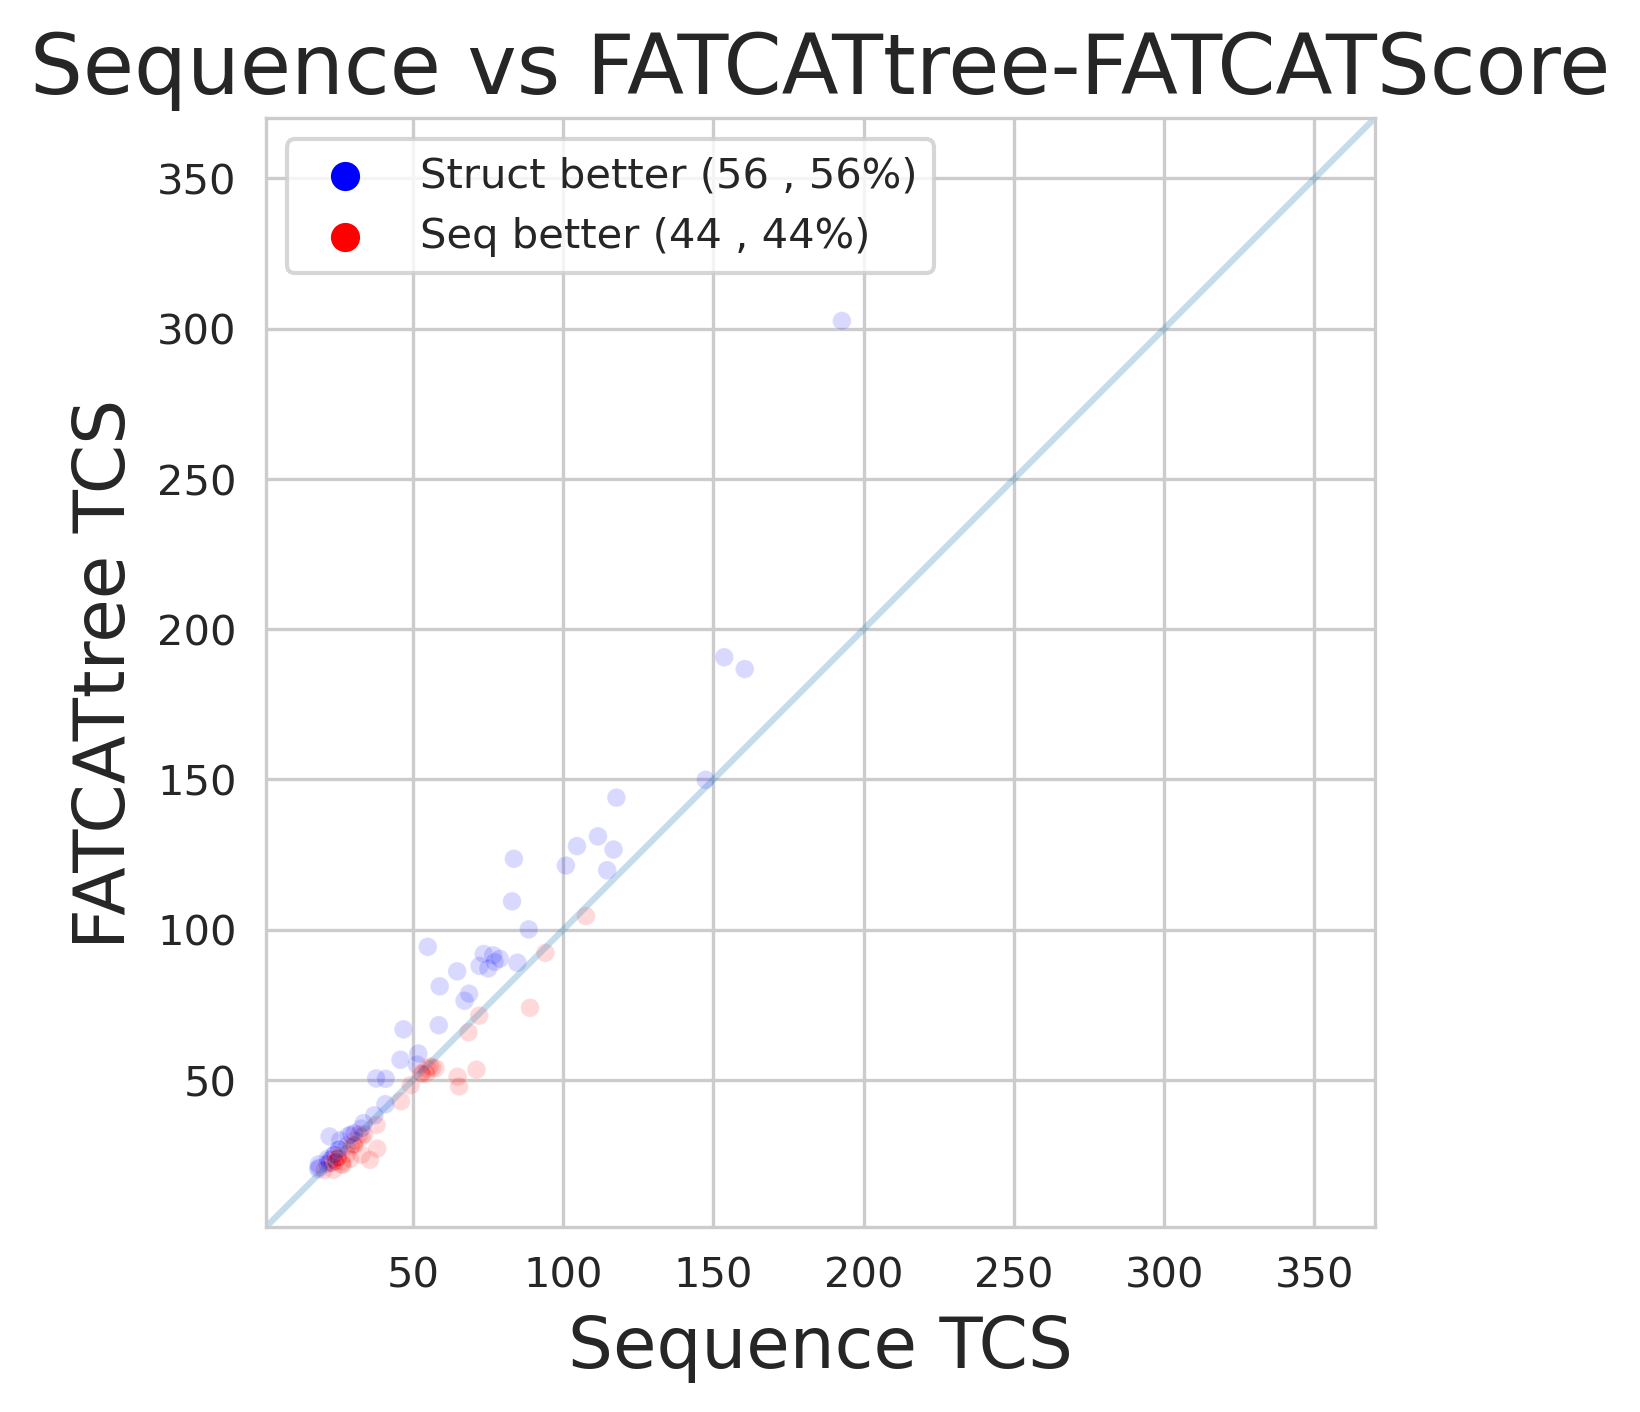

In [15]:
retgraph(  'sequences.aln.muscle.fst.nwk.rooted_norm' , 'score_struct_tree.final_norm' , df 
         ,'Sequence TCS' ,  'FATCATtree TCS',  'Sequence vs FATCATtree-FATCATScore')

[<matplotlib.collections.PathCollection object at 0x7fed21feecd0>, <matplotlib.collections.PathCollection object at 0x7fed220096d0>] ['Seq better', 'Struct better']


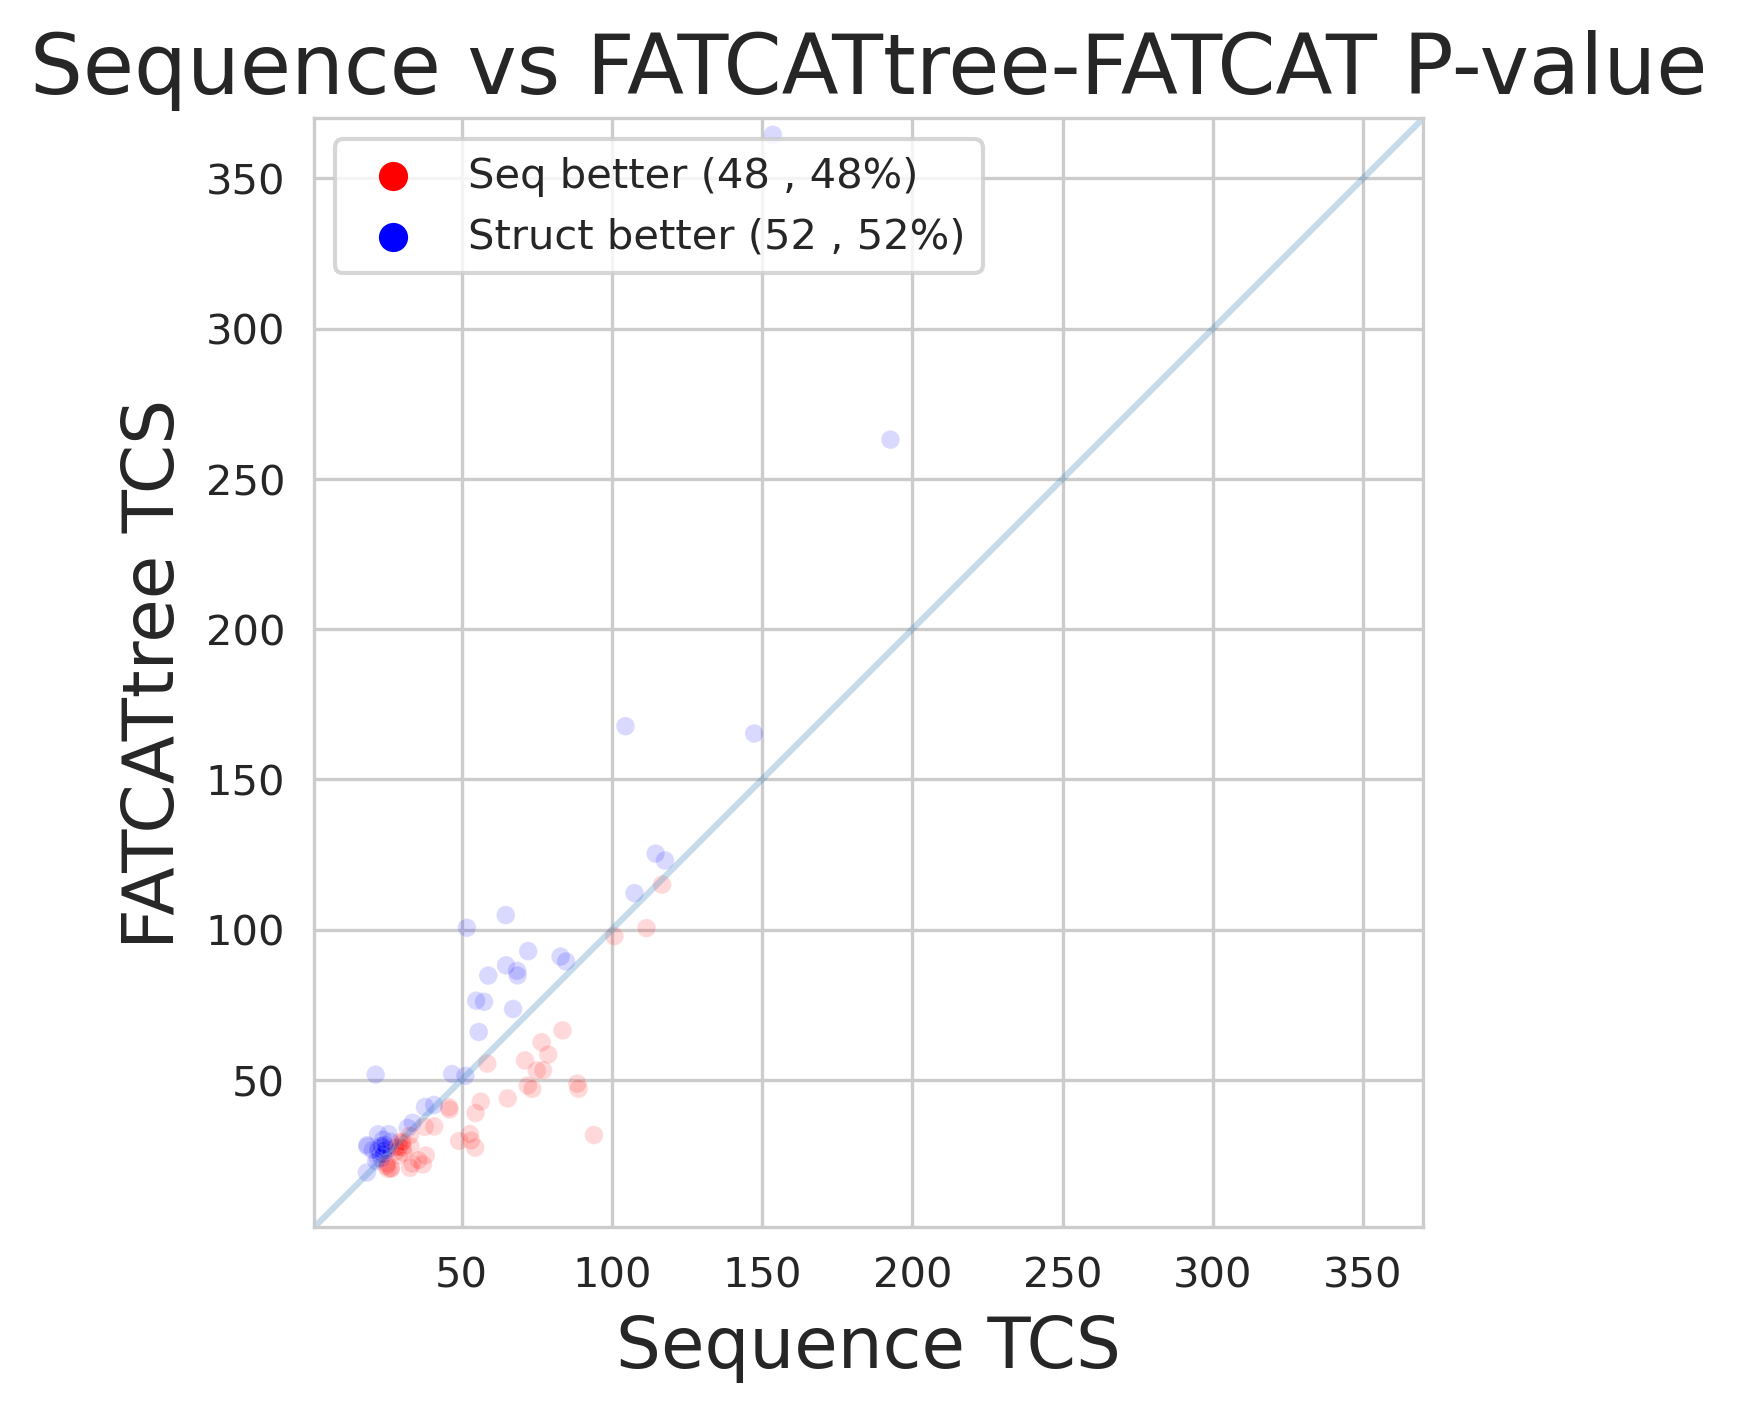

In [16]:
retgraph(  'sequences.aln.muscle.fst.nwk.rooted_norm' , 'p_value_struct_tree.final_norm' , df 
         ,'Sequence TCS' ,  'FATCATtree TCS',  'Sequence vs FATCATtree-FATCAT P-value')

[<matplotlib.collections.PathCollection object at 0x7fed220e14d0>, <matplotlib.collections.PathCollection object at 0x7fed220d6cd0>] ['Seq better', 'Struct better']


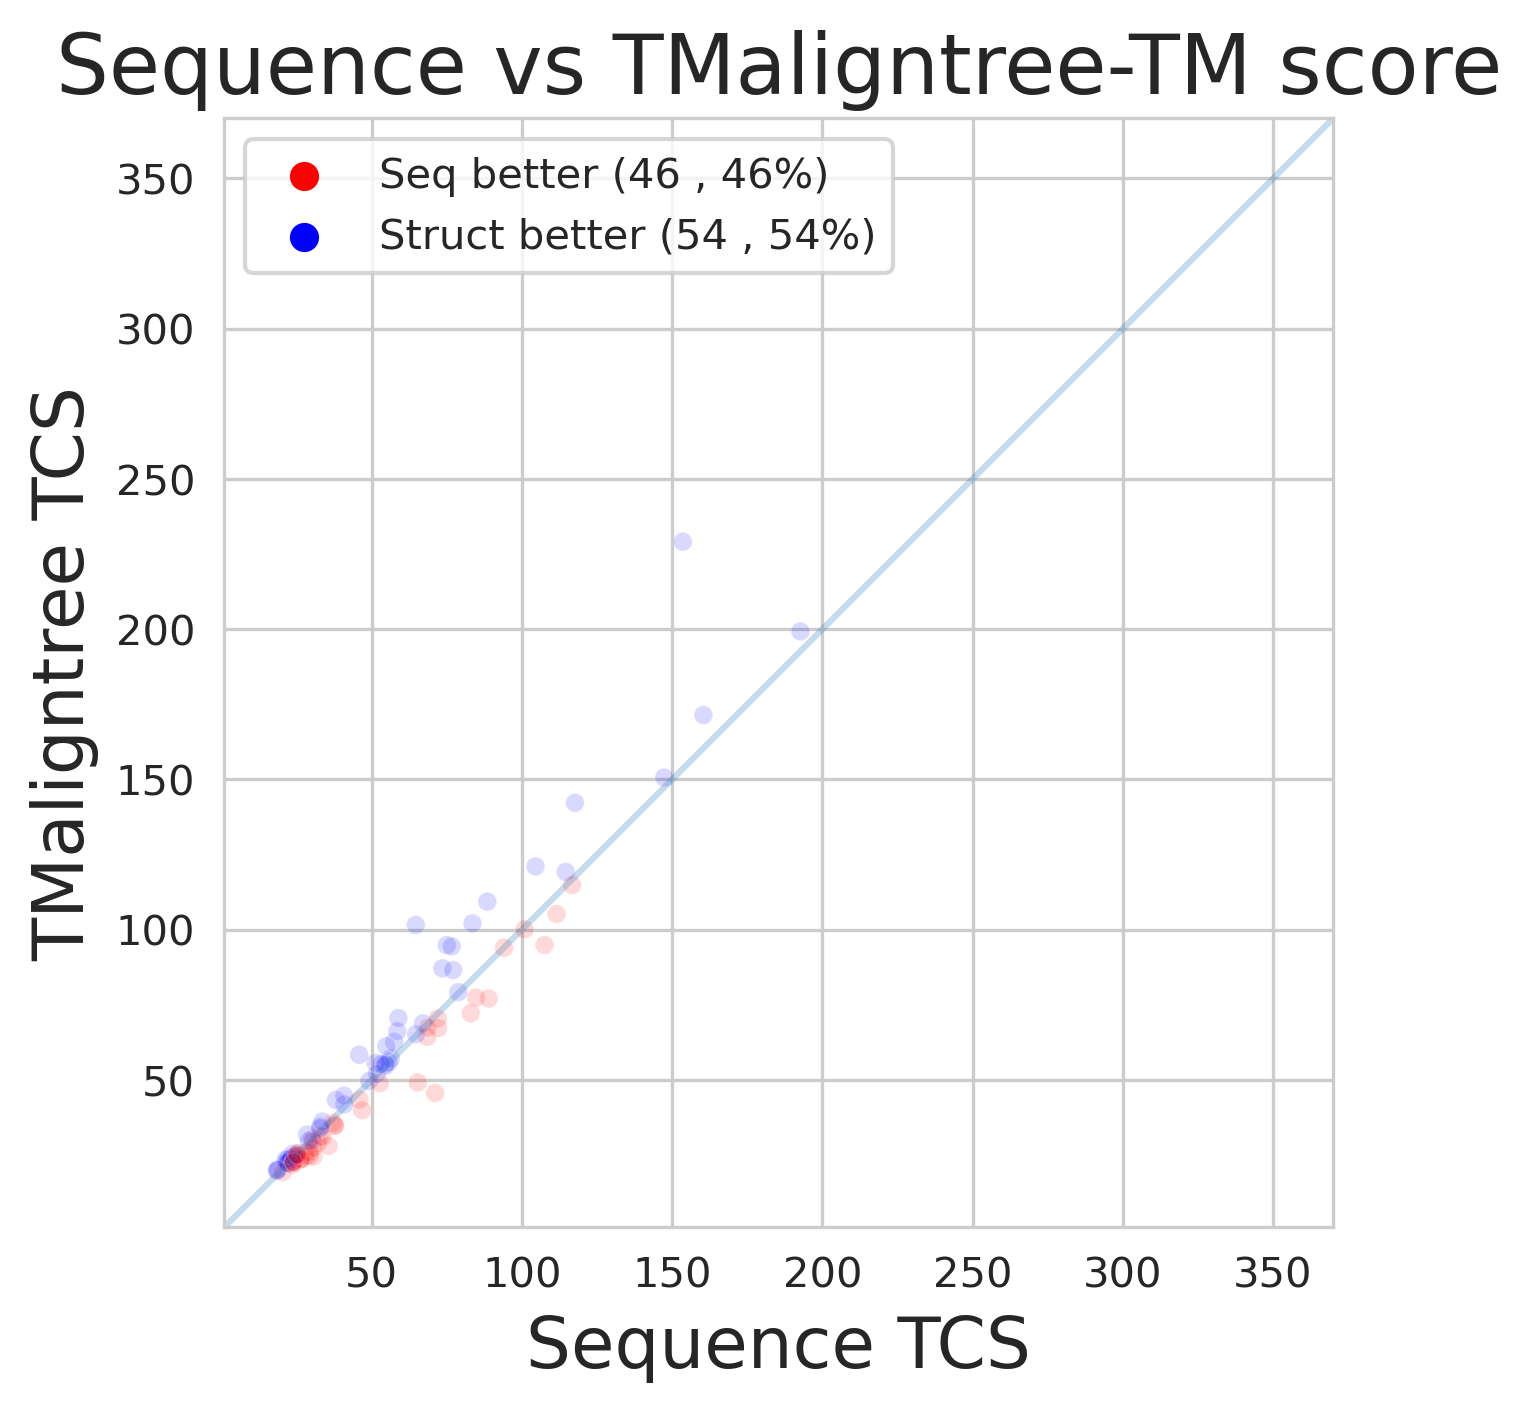

In [14]:
retgraph(  'sequences.aln.muscle.fst.nwk.rooted_norm' , 'alntmscore_1_exp_struct_tree_norm' , df 
         ,'Sequence TCS' ,  'TMaligntree TCS',  'Sequence vs TMaligntree-TM score')

/tmp/ipykernel_3113546/2106164269.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtereddf['structure better'] = filtereddf.apply( ret_winner , args = ( s1,  s2) , axis = 1)


[<matplotlib.collections.PathCollection object at 0x7fed229e2250>, <matplotlib.collections.PathCollection object at 0x7fed229d0c50>, <matplotlib.collections.PathCollection object at 0x7fed229f2d50>] ['Seq better', 'Struct better', 'Equal']


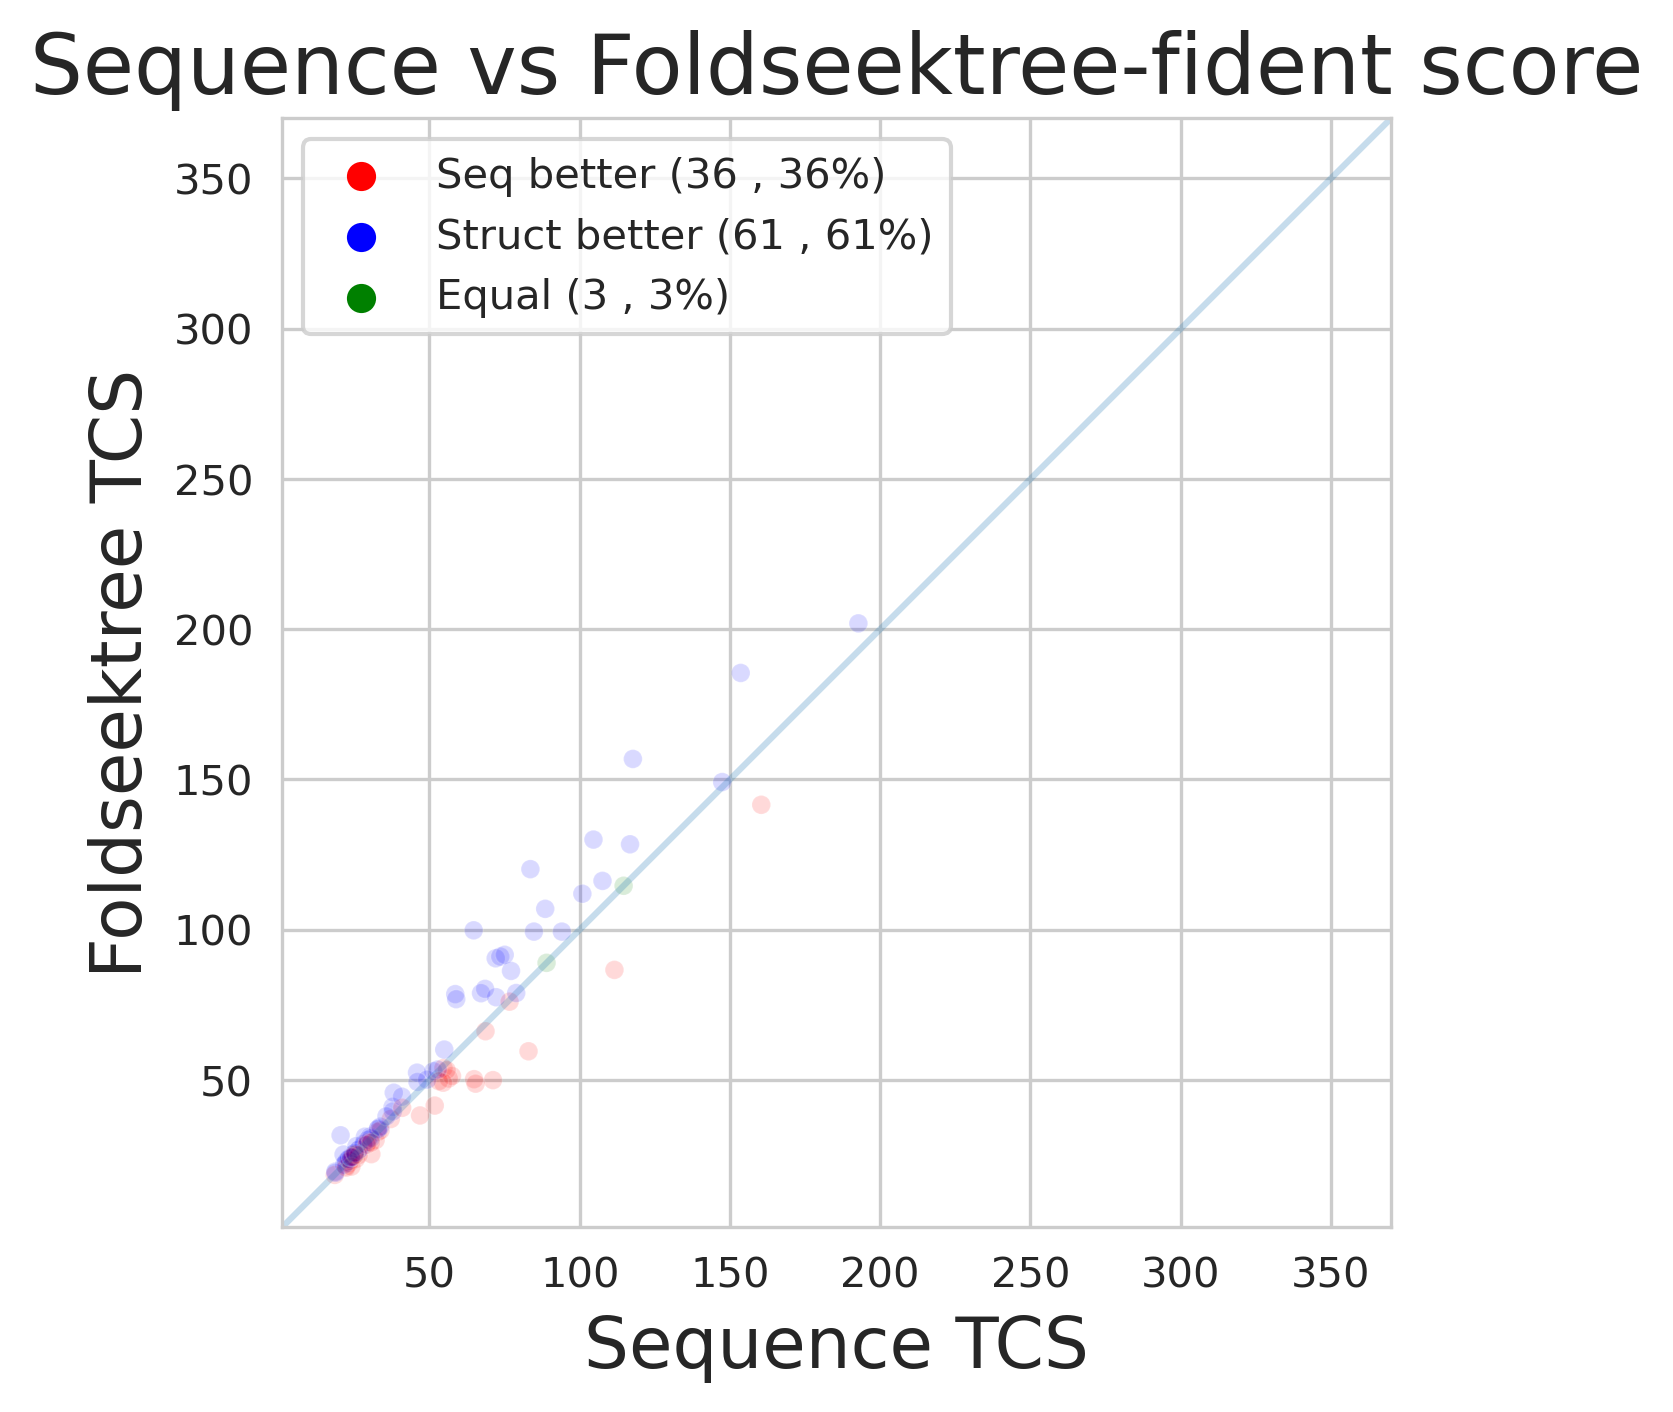

In [11]:
retgraph(  'sequences.aln.muscle.fst.nwk.rooted_norm' , 'fident_1_exp_struct_tree_norm' , df 
         ,'Sequence TCS' ,  'Foldseektree TCS',  'Sequence vs Foldseektree-fident score')